# Week 03 — Dimensionality Reduction & PCA

This notebook builds a complete picture of Principal Component Analysis:
- Geometric intuition: variance-maximising projections
- Mathematical backbone: covariance eigenvectors and SVD
- Practical sklearn comparison, scree plots, reconstruction, whitening
- Downstream application: visualising and classifying compressed data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits, load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
%matplotlib inline

np.random.seed(42)
print('Libraries imported!')

Libraries imported!


In [1]:
import os, pickle

CACHE_DIR = 'cache_week04_pca'
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    with open(os.path.join(CACHE_DIR, f'{key}.pkl'), 'wb') as f:
        pickle.dump(obj, f)

def load_result(key):
    path = os.path.join(CACHE_DIR, f'{key}.pkl')
    if os.path.exists(path):
        with open(path, 'rb') as f:
            return pickle.load(f)
    return None

def cached(key, compute_fn):
    result = load_result(key)
    if result is not None:
        print(f"[cache] loaded '{key}'")
        return result
    print(f"[cache] computing '{key}'...")
    result = compute_fn()
    save_result(key, result)
    return result

print('Cache utilities ready. Results stored in:', CACHE_DIR)

Cache utilities ready. Results stored in: cache_week04_pca


## 1. Geometric Intuition — Variance and Projections

PCA finds the direction $\mathbf{v}$ that **maximises the variance** of the projected data $\mathbf{X v}$.
For centred data this equals maximising $\mathbf{v}^\top \Sigma \mathbf{v}$ where $\Sigma$ is the covariance matrix.
The solution is the **leading eigenvector** of $\Sigma$.

Estimated covariance:
 [[2.89 1.92]
 [1.92 1.89]]
Eigenvalues: [4.375 0.41 ]


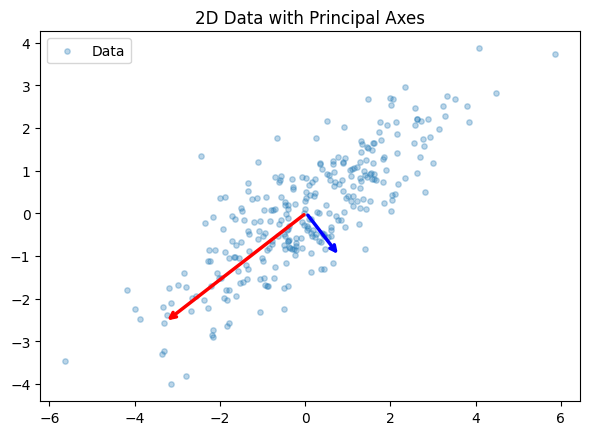

In [3]:
# Generate 2D correlated Gaussian data
cov = np.array([[3.0, 2.0],
                [2.0, 2.0]])
X2d = np.random.multivariate_normal(mean=[0, 0], cov=cov, size=300)

# Compute covariance and eigenvectors
X2d_c = X2d - X2d.mean(axis=0)
cov_hat = np.cov(X2d_c.T)
eigenvalues, eigenvectors = np.linalg.eigh(cov_hat)
# eigh returns ascending order — reverse to get descending
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print('Estimated covariance:\n', np.round(cov_hat, 2))
print('Eigenvalues:', np.round(eigenvalues, 3))

# Plot data and principal axes
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X2d[:, 0], X2d[:, 1], alpha=0.3, s=15, label='Data')
origin = X2d.mean(axis=0)
colors = ['red', 'blue']
for i in range(2):
    v = eigenvectors[:, i] * np.sqrt(eigenvalues[i]) * 2
    ax.annotate('', xy=origin + v, xytext=origin,
                arrowprops=dict(arrowstyle='->', color=colors[i], lw=2.5))
ax.set_aspect('equal')
ax.set_title('2D Data with Principal Axes')
ax.legend()
plt.tight_layout()
plt.show()

## 2. PCA via SVD — From Scratch

For centred data $\tilde{\mathbf{X}}$, the thin SVD gives $\tilde{\mathbf{X}} = U S V^\top$.
The **principal components** (axes) are the rows of $V^\top$.  
The **scores** (projected data) are $\tilde{\mathbf{X}} V = U S$.  
The **explained variance** of component $k$ is $s_k^2 / (n-1)$.

In [4]:
def pca_svd(X, n_components=None):
    """PCA via thin SVD.
    
    Returns
    -------
    scores        : ndarray (n, n_components) — projected data
    components    : ndarray (n_components, p) — principal axes
    expl_var      : ndarray (n_components,)  — explained variance per component
    expl_var_ratio: ndarray (n_components,)  — fraction of total variance
    """
    n = X.shape[0]
    X_c = X - X.mean(axis=0)            # centre
    U, S, Vt = np.linalg.svd(X_c, full_matrices=False)  # thin SVD
    if n_components is not None:
        U, S, Vt = U[:, :n_components], S[:n_components], Vt[:n_components]
    expl_var = (S ** 2) / (n - 1)
    total_var = np.sum((X_c ** 2)) / (n - 1)  # sum of all variances
    expl_var_ratio = expl_var / total_var
    scores = X_c @ Vt.T
    return scores, Vt, expl_var, expl_var_ratio


# Test on iris (4 features → 2 components)
iris = load_iris()
X_iris = iris.data.astype(float)

scores_ours, components_ours, ev_ours, evr_ours = pca_svd(X_iris, n_components=2)

print('Our PCA explained variance ratio:', np.round(evr_ours, 4))

Our PCA explained variance ratio: [0.9246 0.0531]


## 3. Comparison to sklearn.decomposition.PCA

[cache] computing 'sklearn_pca_iris'...
sklearn explained variance ratio: [0.9246 0.0531]
Our   explained variance ratio:   [0.9246 0.0531]
Match: True


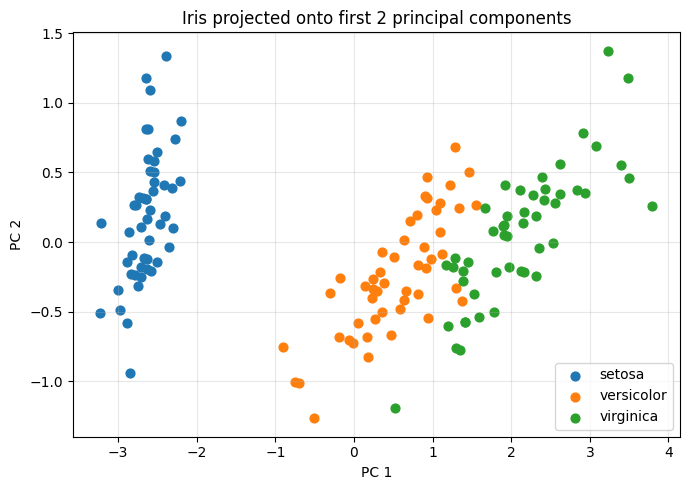

In [5]:
def _run_sklearn_pca_iris():
    sk_pca = PCA(n_components=2)
    sk_pca.fit(X_iris)
    return sk_pca

sk_pca_iris = cached('sklearn_pca_iris', _run_sklearn_pca_iris)

print('sklearn explained variance ratio:', np.round(sk_pca_iris.explained_variance_ratio_, 4))
print('Our   explained variance ratio:  ', np.round(evr_ours, 4))
print('Match:', np.allclose(evr_ours, sk_pca_iris.explained_variance_ratio_, atol=1e-6))

# Plot 2D projection (iris) — coloured by species
scores_sk = sk_pca_iris.transform(X_iris)
plt.figure(figsize=(7, 5))
for i, name in enumerate(iris.target_names):
    mask = iris.target == i
    plt.scatter(scores_sk[mask, 0], scores_sk[mask, 1], label=name, s=40)
plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.title('Iris projected onto first 2 principal components')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

## 4. Scree Plot & Variance Retention (Digits dataset)

[cache] computing 'pca_digits_full'...
Components to retain 95% variance: 29


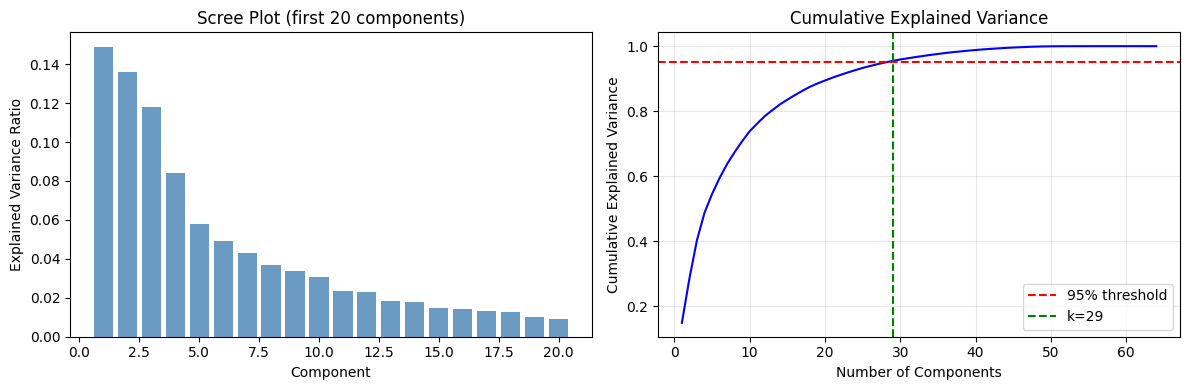

In [6]:
digits = load_digits()
X_digits = digits.data.astype(float)  # 1797 × 64

def _fit_digits_pca():
    pca_full = PCA()  # keep all components
    pca_full.fit(X_digits)
    return pca_full

pca_digits = cached('pca_digits_full', _fit_digits_pca)

evr = pca_digits.explained_variance_ratio_
cumulative_evr = np.cumsum(evr)

# How many components retain >= 95% variance?
k_95 = int(np.searchsorted(cumulative_evr, 0.95)) + 1
print(f'Components to retain 95% variance: {k_95}')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Scree plot
axes[0].bar(range(1, 21), evr[:20], color='steelblue', alpha=0.8)
axes[0].set_xlabel('Component'); axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot (first 20 components)')
# Cumulative EVR
axes[1].plot(range(1, len(evr) + 1), cumulative_evr, 'b-')
axes[1].axhline(0.95, color='red', linestyle='--', label='95% threshold')
axes[1].axvline(k_95, color='green', linestyle='--', label=f'k={k_95}')
axes[1].set_xlabel('Number of Components'); axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

## 5. Reconstruction Visualisation

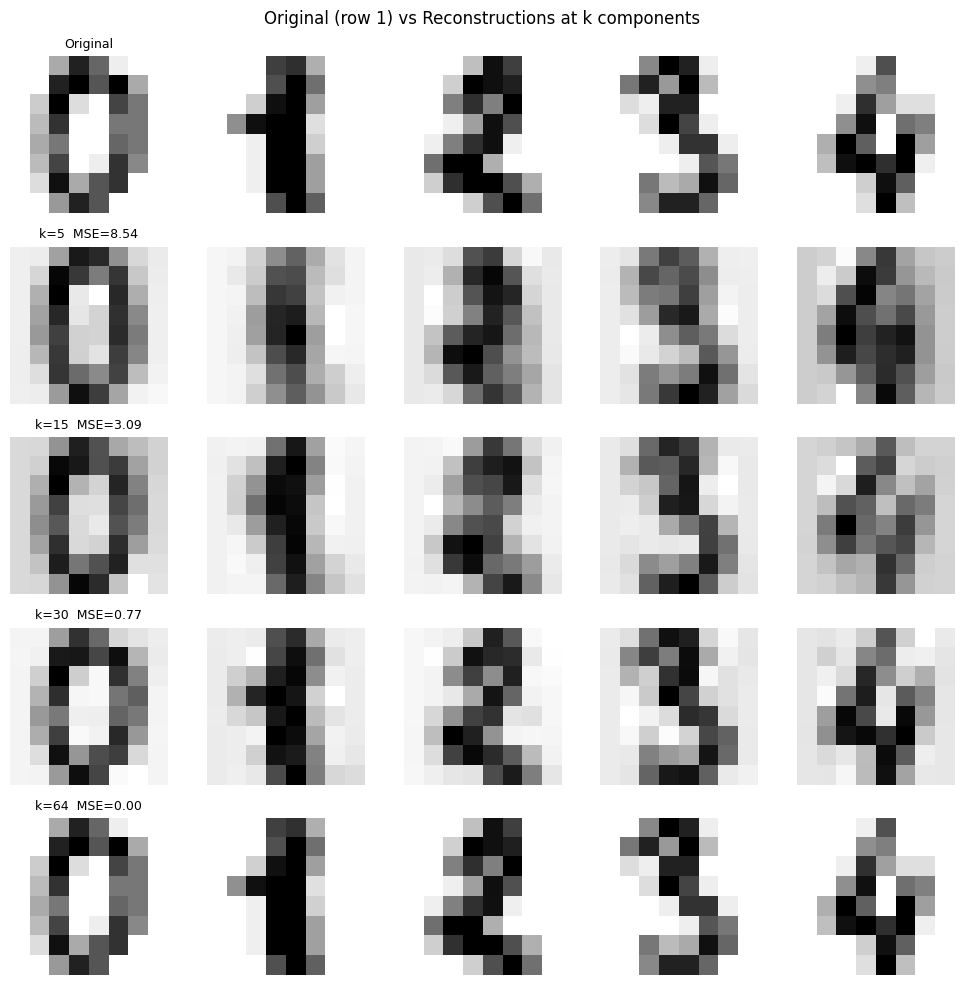

In [7]:
def reconstruct_pca(X, pca_model, n_components):
    """Project to n_components PCs and reconstruct back to input space."""
    scores = pca_model.transform(X)[:, :n_components]
    components = pca_model.components_[:n_components]
    return scores @ components + pca_model.mean_


k_values = [5, 15, 30, 64]
n_show = 5  # images to show

fig, axes = plt.subplots(len(k_values) + 1, n_show, figsize=(10, 10))
fig.suptitle('Original (row 1) vs Reconstructions at k components', fontsize=12)

for j in range(n_show):
    axes[0, j].imshow(X_digits[j].reshape(8, 8), cmap='gray_r')
    axes[0, j].axis('off')
    if j == 0:
        axes[0, j].set_title('Original', fontsize=9)

for i, k in enumerate(k_values):
    X_rec = reconstruct_pca(X_digits, pca_digits, k)
    mse = np.mean((X_digits - X_rec) ** 2)
    for j in range(n_show):
        axes[i + 1, j].imshow(X_rec[j].reshape(8, 8), cmap='gray_r')
        axes[i + 1, j].axis('off')
    if n_show > 0:
        axes[i + 1, 0].set_title(f'k={k}  MSE={mse:.2f}', fontsize=9)

plt.tight_layout()
plt.show()

## 6. PCA Whitening

**Whitening** scales the projected data so that each principal component has unit variance:
$\mathbf{X}_{\text{white}} = \mathbf{X}_{\text{scores}} \cdot \text{diag}(\lambda)^{-1/2}$.  
The resulting covariance is approximately $I$, which is useful for algorithms that assume uncorrelated, unit-variance inputs.

In [8]:
def pca_whitening(X, n_components=None):
    """PCA with whitening: returns scores scaled to unit variance."""
    scores, components, expl_var, evr = pca_svd(X, n_components=n_components)
    X_white = scores / np.sqrt(expl_var)  # divide each column by std
    return X_white


X_white = pca_whitening(X_iris, n_components=4)
cov_white = np.cov(X_white.T)

print('Covariance of whitened iris (should be ~I):')
print(np.round(cov_white, 3))
print('\nDiag ~ 1:', np.allclose(np.diag(cov_white), np.ones(4), atol=0.05))
print('Off-diag ~ 0:', np.allclose(cov_white - np.diag(np.diag(cov_white)), 0, atol=0.05))

Covariance of whitened iris (should be ~I):
[[ 1. -0. -0. -0.]
 [-0.  1.  0.  0.]
 [-0.  0.  1.  0.]
 [-0.  0.  0.  1.]]

Diag ~ 1: True
Off-diag ~ 0: True


## 7. Downstream Classification — Original vs PCA-compressed

In [9]:
def _run_classification_experiments():
    results = {}
    knn = KNeighborsClassifier(n_neighbors=5)
    # Original (64 features)
    acc_full = cross_val_score(knn, X_digits, digits.target, cv=5).mean()
    results['full (64)'] = acc_full
    # PCA-compressed
    for k in [10, k_95, 30, 64]:
        pca_k = PCA(n_components=k)
        X_k = pca_k.fit_transform(X_digits)
        acc = cross_val_score(knn, X_k, digits.target, cv=5).mean()
        results[f'PCA k={k}'] = acc
    return results

results = cached('knn_pca_digits', _run_classification_experiments)

print('5-fold cross-validated accuracy — KNN(k=5) on Digits')
for name, acc in results.items():
    print(f'  {name:<15}: {acc:.4f}')

[cache] computing 'knn_pca_digits'...
5-fold cross-validated accuracy — KNN(k=5) on Digits
  full (64)      : 0.9627
  PCA k=10       : 0.9371
  PCA k=29       : 0.9627
  PCA k=30       : 0.9622
  PCA k=64       : 0.9627


## Exercises

1. **PCA from SVD** — verify that `pca_svd` explained variances match `sklearn.decomposition.PCA` on `digits` (tolerance `1e-6`).
2. **Variance retention** — choose k to retain ≥ 95% variance; plot reconstruction MSE vs k.
3. **Reconstruction visualisation** — show original vs reconstructed `digits` images at k = 5, 15, 30, 60.
4. **Whitening** — apply `pca_whitening` and verify the resulting covariance is approximately `I`.
5. **Downstream classification** — compare KNN accuracy on original vs PCA-compressed features; report speed-up (use `%%timeit`).

In [10]:
# EXERCISE 1 — PCA from SVD vs sklearn
# Goal: call pca_svd(X_digits, n_components=64) and compare explained_variance_ratio
# to PCA(n_components=64).fit(X_digits).explained_variance_ratio_.
# Assert np.allclose(..., atol=1e-6).

In [11]:
# EXERCISE 2 — Reconstruction MSE vs k
# Goal: compute MSE of reconstruct_pca(X_digits, pca_digits, k) for k in range(1, 65).
# Plot MSE vs k. Mark k_95 with a vertical dashed line.
# Expected: MSE decreases monotonically; reconstruction is near-perfect at k=64.

In [12]:
# EXERCISE 3 — Reconstruction image grid
# Goal: show a 5×5 grid: rows = k in [5, 15, 20, 30, 64], columns = 5 random digits.
# Add axes labels with MSE per row.

In [13]:
# EXERCISE 4 — Whitening verification
# Goal: apply pca_whitening(X_digits, n_components=k_95).
# Check that np.cov(X_white.T) is close to np.eye(k_95) (atol=0.1).

In [14]:
# EXERCISE 5 — Speed-up benchmark
# Goal: use %%timeit to compare KNN fit+predict on full 64 features vs k_95 features.
# Report the ratio. Discuss accuracy/speed trade-off.